# Сравнение групп методами bootstrap и критерием Манна-Уитни

**Описание данных:** 
Дана таблица, где числовая переменная – непрерывная.
- value – значения метрики
- experimentVariant – вариант теста (Control – контроль, Treatment – тест)  

**Задача:**  
Сравните результат между тестом и контролем по двум кейсам:
- Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
- Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

plt.style.use('ggplot')

Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [2]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--', colors='black')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [3]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv', sep=';', decimal=',')

In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
df.head()

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control


In [6]:
df.shape

(1000, 2)

In [7]:
df.dtypes

value                float64
experimentVariant     object
dtype: object

In [8]:
df.groupby('experimentVariant').agg({'value': 'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,27.321499


In [9]:
df.groupby('experimentVariant').agg({'value': 'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.025847


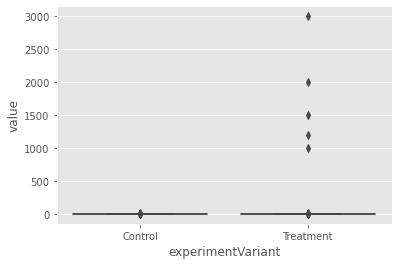

In [10]:
sns.boxplot(x="experimentVariant", y="value", data=df);

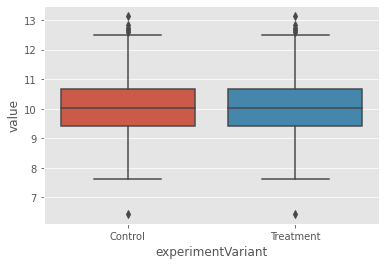

In [11]:
sns.boxplot(x="experimentVariant", y="value", data=df[df.value < 100]);

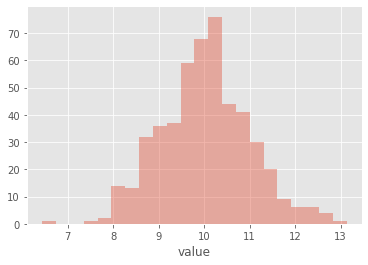

In [14]:
sns.distplot(df.query('experimentVariant == "Control"').value, kde=False);

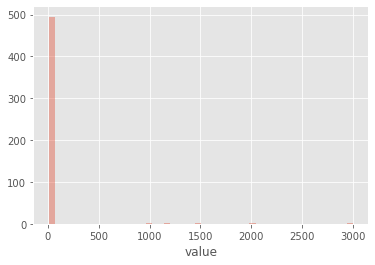

In [15]:
sns.distplot(df.query('experimentVariant == "Treatment"').value, kde=False);

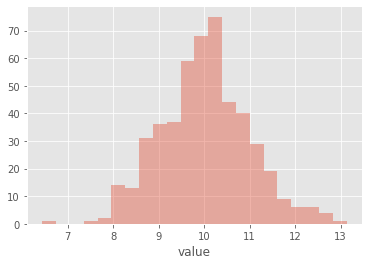

In [16]:
sns.distplot(df.query('experimentVariant == "Treatment" & value < 100').value, kde=False);

In [17]:
# данные, которые различаются у контрольной и тестовой групп (остальные полностью совпадают)
df.drop_duplicates(subset = 'value', keep=False)

,value,experimentVariant
495,10.973929,Control
496,10.261074,Control
497,8.780090,Control
498,11.169078,Control
499,11.499566,Control
995,1000.000000,Treatment
996,1200.000000,Treatment
997,1500.000000,Treatment
998,2000.000000,Treatment
999,3000.000000,Treatment


Применяем критерий Манна-Уитни для сравнения двух групп

In [18]:
mv = mannwhitneyu(df[df.experimentVariant == 'Treatment'].value, 
             df[df.experimentVariant == 'Control'].value)
mv

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

Применяем бутстрап (с np.mean)

  0%|          | 0/2000 [00:00<?, ?it/s]

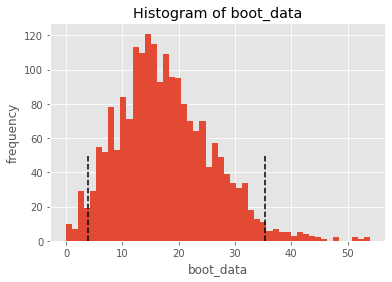

In [19]:
booted_data_mean = get_bootstrap(
    df[df.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    df[df.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [20]:
booted_data_mean["p_value"]

0.034707210636780776

In [21]:
booted_data_mean["ci"]

,0
0.025,3.909263
0.975,35.267626


**Cравниваем p-value бутстрапа (с np.mean) и критерия mann-whitney:**  
Критерий Манна-Уитни с pvalue=0.43 говорит нам о том, что статичтически значимых различий между выборками нет 
(недостаточно оснований для отклонения гипотезы о равенстве распределений двух выборок),  
в то время как бутстрап (с np.mean) с pvalue=0.03 говорит нам о том, что статистически значимые различия есть 
(достаточно оснований для отклонения гипотезы о равенстве средних между выборками).

In [27]:
print('mann-whitney pvalue < 0.05: ', mv.pvalue < 0.05)
print('bootstrap (np.mean) pvalue < 0.05: ', booted_data_mean["p_value"] < 0.05)

mann-whitney pvalue < 0.05:  False
bootstrap (np.mean) pvalue < 0.05:  True


Применяем бутстрап (с np.median)

  0%|          | 0/2000 [00:00<?, ?it/s]

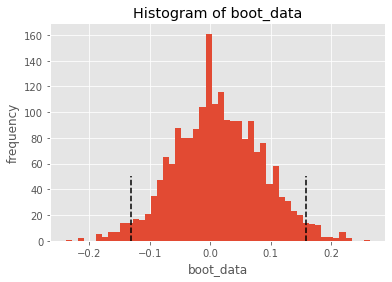

In [23]:
booted_data_median = get_bootstrap(
    df[df.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    df[df.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [24]:
booted_data_median["p_value"]

0.8547533665427668

In [25]:
booted_data_median["ci"]

,0
0.025,-0.132056
0.975,0.158390


**Сравниваем p-value бутстрапа (с np.median) и критерия mann-whitney:**  
Критерий Манна-Уитни с pvalue=0.43 говорит нам о том, что статичтически значимых различий между выборками нет 
(недостаточно оснований для отклонения гипотезы о равенстве распределений двух выборок),  
бутстрап (с np.median) с pvalue=0.85 говорит нам о том, что статичтически значимых различий нет 
(недостаточно оснований для отклонения гипотезы о равенстве медиан между выборками).

In [28]:
print('mann-whitney pvalue < 0.05: ', mv.pvalue < 0.05)
print('bootstrap (np.median) pvalue < 0.05: ', booted_data_median["p_value"] < 0.05)

mann-whitney pvalue < 0.05:  False
bootstrap (np.median) pvalue < 0.05:  False


**Выводы:** Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия. Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value больше 0.05.  
U-критерий Манна-Уитни также не даёт нам отклонить нулевую гипотезу и говорит нам о равенстве распределений.  
Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение, поэтому бутстрап даёт разные результаты при оценке среднего и медианы.